In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Fold & Unfold

## Unfold

### Official Documentation 

Extracts sliding local blocks from a batched input tensor.

Consider an batched `input` tensor of shape $(N, C, *)$, where $N$ is the batch dimension, $C$ is the channel dimension, and $*$ represent arbitrary spatial dimensions. This operation flattens each sliding kernel_size-sized block within the spatial dimensions of input into a column (i.e., last dimension) of a 3-D output tensor of shape $(N, C \times \prod(\text{kernel_size}), L)$, where $C \times \prod(\text{kernel_size})$ is the total number of values within each block (a block has $\prod(\text{kernel_size})$ spatial locations each containing a $C$-channeled vector), and $L$ is the total number of such blocks:

$$L= \prod_d \left\lfloor \frac{\text{spatial_size}[d]+2\times \text{padding}[d]-\text{dilation}[d]\times(\text{kernel_size}[d]-1)-1}{\text{stride}[d]} +1 \right\rfloor,$$

where $\text{spatial_size}$ is formed by the spatial dimensions of `input` ($*$ above), and $d$ is over all spatial dimensions.

Therefore, indexing `output` at the last dimension (column dimension) gives all values within a certain block.

The `padding`, `stride` and `dilation` arguments specify how the sliding blocks are retrieved.

* `stride` controls the stride for the sliding blocks.
* `padding` controls the amount of implicit zero-paddings on both sides for padding number of points for each dimension before reshaping.
* `dilation` controls the spacing between the kernel points; also known as the à trous algorithm. It is harder to describe, but this [link](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) has a nice visualization of what dilation does.

## Fold

### 공식문서 설명 

Combines an array of sliding local blocks into a large containing tensor.

Consider a batched `input` tensor containing sliding local blocks, e.g., patches of images, of shape $(N, C \times \prod(\text{kernel_size}), L)$, where $N$ is batch dimension, $C \times \prod(\text{kernel_size})$ is the number of values within a block (a block has $\prod(\text{kernel_size})$ spatial locations each containing a $C$-channeled vector), and $L$ is the total number of blocks. (This is exactly the same specification as the output shape of `Unfold`.) This operation combines these local blocks into the large `output` tensor of shape $(N, C, \text{output_size}[0], \text{output_size}[1], \dots)$ by summing the overlapping values. Similar to `Unfold`, the arguments must satisfy

$$L= \prod_d \left\lfloor \frac{\text{output_size}[d]+2\times \text{padding}[d]-\text{dilation}[d]\times(\text{kernel_size}[d]-1)-1}{\text{stride}[d]} +1 \right\rfloor,$$

where $d$ is over all spatial dimensions.

* `output_size` describes the spatial shape of the large containing tensor of the sliding local blocks. It is useful to resolve the ambiguity when multiple input shapes map to same number of sliding blocks, e.g., with `stride > 0`.

The `padding`, `stride` and `dilation` arguments specify how the sliding blocks are retrieved.

* `stride` controls the stride for the sliding blocks.
* `padding` controls the amount of implicit zero-paddings on both sides for padding number of points for each dimension before reshaping.
* `dilation` controls the spacing between the kernel points; also known as the à trous algorithm. It is harder to describe, but this [link](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) has a nice visualization of what dilation does.

## Convolutional Operation

First, set a simple task, the image has size of 5 by 5(Height $H$, Width $W$), has RGB channel($C$). kernel(filter) size is 3 by 3(Kernel Height $K_1$, Kernel Width $K_2$), no padding($P$), stride is 1(Stride for Height $S_1$, Stride for Width $S_2$). $B$ is batch size. 

So we can calculate the size after convolutional operation(`new_H` and `new_W`) by foumula.

In [2]:
B, C, H, W = 1, 3, 5, 5
K1, K2 = 3, 3
P = 1
S1, S2 = 1, 1
padding = 0
kernel = (K1, K2)
stride = (S1, S2)

# Calculate the size that after convolution
new_H = int(np.floor((H + 2*padding - kernel[0]) / stride[0] + 1))
new_W = int(np.floor((W + 2*padding - kernel[0]) / stride[0] + 1))

create a img like below

img size is  torch.Size([1, 3, 5, 5])


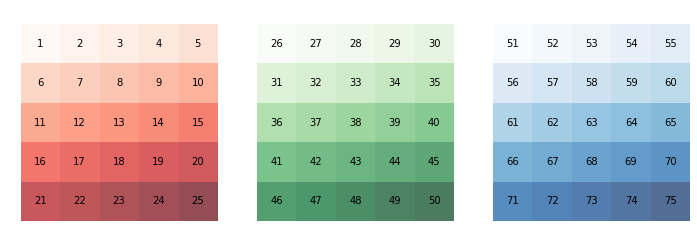

In [3]:
img = torch.arange(1, B*C*H*W+1).view(B, C, H, W).float()
print("img size is ", img.size())

fig = plt.figure(figsize=(12, 4))
axes = fig.subplots(1, 3)
color_maps = ["Reds", "Greens", "Blues"]  # RGB channel colors
for mat, ax, cmap in zip(img[0], axes, color_maps):
    ax.matshow(mat, cmap=cmap, alpha=0.7)
    ax.axis("off")
    for (i, j), z in np.ndenumerate(mat):
        ax.text(j, i, '{:d}'.format(int(z)), ha='center', va='center')
plt.show()

Let's see how convolutional operatation works

In [4]:
# Drawing how convolutional operation works
mat_figs = []

fig = plt.figure(figsize=(12, 4))
axes = fig.subplots(1, 3)

for i, (mat, ax, cmap) in enumerate(zip(img[0], axes, color_maps)):
    mat_fig = ax.matshow(mat, cmap=cmap, alpha=0.7)
    ax.axis("off")
    ax.set_title(f"CH:{i+1}")
    for (i, j), z in np.ndenumerate(mat):
        ax.text(j, i, '{:d}'.format(int(z)), ha='center', va='center')
    mat_figs.append(mat_fig)

def animate(i):
    temp = np.zeros((int(C*np.array(kernel).prod()), new_H*new_W))
    temp[i:int(C*np.array(kernel).prod()):new_H*new_W] = 1
    masks = torch.nn.functional.fold(torch.FloatTensor(temp).unsqueeze(0), (H, W), kernel)
    for mat, mask, mat_fig in zip(img[0], masks[0], mat_figs):
        mat_fig.set_data(mat*mask)
    return mat_figs
            
ani = animation.FuncAnimation(fig, animate, frames=new_H*new_W, interval=300)
plt.close()
HTML(ani.to_html5_video())

## Unfold

In [5]:
torch.manual_seed(99)
C_out = 5

unfold_img = torch.nn.functional.unfold(img, kernel)   # result size: B, (C*K1*K2), (new_H*new_W)
kernel_tensor = torch.randn((C_out, C, *kernel))  # init a random kernel: (C_out, C, K1, K2)
unfold_kernel = kernel_tensor.view(C_out, -1)
matmul_img = unfold_img.transpose(1, 2).matmul(unfold_kernel.t()).transpose(1, 2)
output_img = matmul_img.view(-1, new_H, new_W)

In [6]:
conv_layer = nn.Conv2d(C, C_out, kernel_size=kernel, bias=False)
conv_layer.weight.data = kernel_tensor
conv_layer(img)

tensor([[[[-137.4556, -141.0836, -144.7117],
          [-155.5957, -159.2238, -162.8518],
          [-173.7359, -177.3639, -180.9920]],

         [[ -49.0252,  -44.6367,  -40.2482],
          [ -27.0826,  -22.6941,  -18.3056],
          [  -5.1400,   -0.7515,    3.6370]],

         [[-134.6243, -138.3775, -142.1307],
          [-153.3902, -157.1434, -160.8965],
          [-172.1561, -175.9092, -179.6624]],

         [[-339.6224, -347.4803, -355.3381],
          [-378.9118, -386.7699, -394.6277],
          [-418.2014, -426.0593, -433.9172]],

         [[   2.8660,    3.8062,    4.7464],
          [   7.5669,    8.5071,    9.4472],
          [  12.2678,   13.2080,   14.1481]]]],
       grad_fn=<MkldnnConvolutionBackward>)

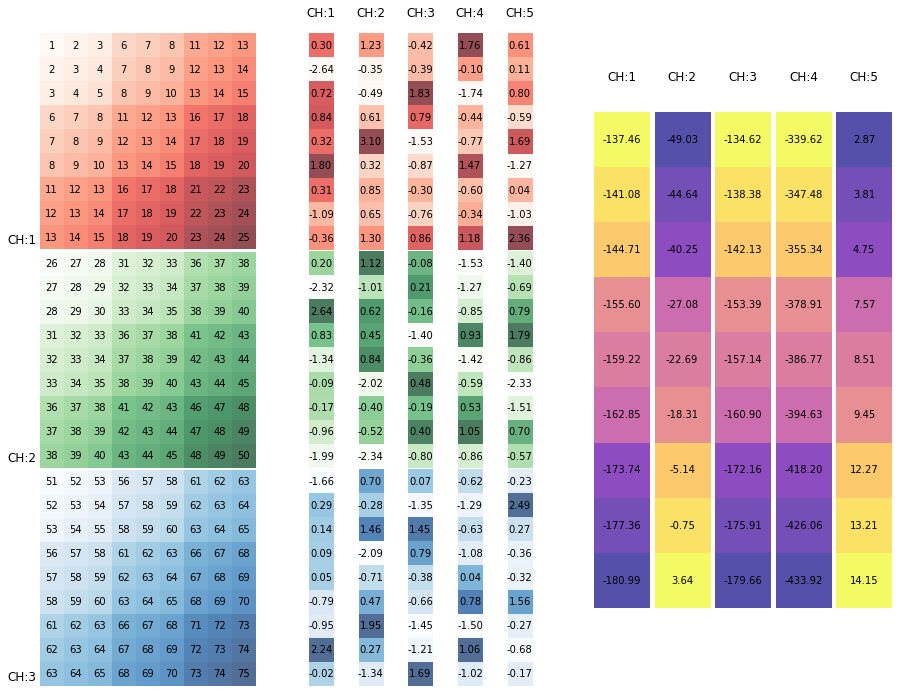

In [32]:
torch.manual_seed(99)
C_out = 5

unfold_img = torch.nn.functional.unfold(img, kernel)   # result size: B, (C*K1*K2), (new_H*new_W)
kernel_tensor = torch.randn((C_out, C, *kernel))  # init a random kernel: (C_out, C, K1, K2)
unfold_kernel = kernel_tensor.view(C_out, -1)
matmul_img = unfold_img.transpose(1, 2).matmul(unfold_kernel.t()).transpose(1, 2)
output_img = matmul_img.view(-1, new_H, new_W)

# Drawing how convolutional operation works
fig = plt.figure(figsize=(16, 12), constrained_layout=False)
outer_grids = fig.add_gridspec(1, 3, wspace=0.0, hspace=0.0)
left_inner_grids = outer_grids[0].subgridspec(3, 1, wspace=0.0, hspace=0.01)
# mid_inner_grids = outer_grids[1].subgridspec(3, 7, wspace=0.0, hspace=0.01)
mid_inner_grids = outer_grids[1].subgridspec(3, 6, wspace=0.0, hspace=0.005)
# right_inner_grids = outer_grids[2].subgridspec(3, 5, wspace=0.1, hspace=0.01)
right_inner_grids = outer_grids[2].subgridspec(1, 5, wspace=0.1, hspace=0.01)

for i, (cmap, grid) in enumerate(zip(color_maps, left_inner_grids)):
    ax = fig.add_subplot(grid)
    left_mat = unfold_img[0][i*(new_H*new_W):(i+1)*(new_H*new_W), :]
    ax.matshow(left_mat, cmap=cmap, alpha=0.7)
    ax.axis("off")
    ax.set_title(f"CH:{i+1}", loc="left", x=-0.15, y=-0.001)
    for (i, j), z in np.ndenumerate(left_mat):
        ax.text(j, i, '{:d}'.format(int(z)), ha='center', va='center')

# for i, grid in enumerate([mid_inner_grids[j] for j in range(21) if ((j % 7 != 0) and (j % 7 != 6))]):
for i, grid in enumerate([mid_inner_grids[j] for j in range(18) if (j % 6 != 5)]):
    ax = fig.add_subplot(grid)
    c = i % C_out
    r = i // C_out
    mid_mat = unfold_kernel.t()[r*(new_H*new_W):(r+1)*(new_H*new_W), c:(c+1)]
    ax.matshow(mid_mat, cmap=color_maps[r], alpha=0.7)
    ax.axis("off")
    if r == 0:
        ax.set_title(f"CH:{i+1}")
    for (i, j), z in np.ndenumerate(mid_mat):
        ax.text(j, i, '{:.2f}'.format(z), fontdict={"fontsize":10}, ha='center', va='center')

for i, grid in enumerate(right_inner_grids):
    ax = fig.add_subplot(grid) 
    right_mat = matmul_img[0].t()[:, i:(i+1)]
    ax.matshow(right_mat, cmap="plasma", alpha=0.7)
    ax.axis("off")
    ax.set_title(f"CH:{i+1}")
    for (i, j), z in np.ndenumerate(right_mat):
        ax.text(j, i, '{:.2f}'.format(z), fontdict={"fontsize":10}, ha='center', va='center')
plt.show()

In [81]:
# save figs
left_figs = []
mid_figs= []
right_figs = []
right_texts = []

# Drawing how convolutional operation works
fig = plt.figure(figsize=(16, 12), constrained_layout=False)
outer_grids = fig.add_gridspec(1, 3, wspace=0.0, hspace=0.0)
left_inner_grids = outer_grids[0].subgridspec(3, 1, wspace=0.0, hspace=0.01)
mid_inner_grids = outer_grids[1].subgridspec(3, 6, wspace=0.0, hspace=0.005)
right_inner_grids = outer_grids[2].subgridspec(1, 5, wspace=0.1, hspace=0.01)

for i, (cmap, grid) in enumerate(zip(color_maps, left_inner_grids)):
    ax = fig.add_subplot(grid)
    left_mat = unfold_img[0][i*(new_H*new_W):(i+1)*(new_H*new_W), :]
    left_fig = ax.matshow(left_mat, cmap=cmap, alpha=0.7)
    ax.axis("off")
    ax.set_title(f"CH:{i+1}", loc="left", x=-0.15, y=-0.001)
    for (i, j), z in np.ndenumerate(left_mat):
        ax.text(j, i, '{:d}'.format(int(z)), ha='center', va='center')
    left_figs.append(left_fig)

for i, grid in enumerate([mid_inner_grids[j] for j in range(18) if (j % 6 != 5)]):
    ax = fig.add_subplot(grid)
    c = i % C_out
    r = i // C_out
    mid_mat = unfold_kernel.t()[r*(new_H*new_W):(r+1)*(new_H*new_W), c:(c+1)]
    mid_fig = ax.matshow(mid_mat, cmap=color_maps[r], alpha=0.7)
    ax.axis("off")
    if r == 0:
        ax.set_title(f"CH:{i+1}")
    for (i, j), z in np.ndenumerate(mid_mat):
        ax.text(j, i, '{:.2f}'.format(z), fontdict={"fontsize":10}, ha='center', va='center')
    mid_figs.append(mid_fig)
    
for i, grid in enumerate(right_inner_grids):
    ax = fig.add_subplot(grid) 
    right_mat = matmul_img[0].t()[:, i:(i+1)]
    right_fig = ax.matshow(right_mat, cmap="plasma", alpha=0.7)
    ax.axis("off")
    ax.set_title(f"CH:{i+1}")
    for (i, j), z in np.ndenumerate(right_mat):
        right_text = ax.text(j, i, '{:.2f}'.format(z), fontdict={"fontsize":10}, ha='center', va='center')
        right_texts.append(right_text)
    right_figs.append(right_fig)
    
    
def animate(j):
    left_mask = np.zeros((int(C*np.array(kernel).prod()), new_H*new_W))  # 27, 9
    right_mask = np.ones((new_H*new_W, C_out))  # 9, 5
    n_out_unfold_r = j % (new_H*new_W)  # total 9 iters 
    n_out_ch = j // (new_H*new_W)  # total 5 iters
    
    left_mask[:, n_out_unfold_r] = 1
    right_mask[n_out_unfold_r, n_out_ch] = np.inf    
    
    for k, left_fig in enumerate(left_figs): # 3 figs
        select_mat = unfold_img[0][k*(new_H*new_W):(k+1)*(new_H*new_W), :].numpy()
        select_mask = left_mask[k*(new_H*new_W):(k+1)*(new_H*new_W), :]
        left_fig.set_data(select_mat*select_mask)
        
    for k, mid_fig in enumerate(mid_figs): # 15 figs
        c = k % C_out
        r = k // C_out
        if c != n_out_ch:
            mid_fig.set_cmap("gray")
        else:
            mid_fig.set_cmap(color_maps[r])
    
    for k, right_fig in enumerate(right_figs): # 5 figs
        
        select_mat = matmul_img[0].t()[:, k:(k+1)].numpy()
        select_mask = right_mask[:, k:(k+1)]
        right_fig.set_data((select_mat*select_mask))
        
        if k != n_out_ch:
            right_fig.set_cmap("gray")
        else:
            right_fig.set_cmap("plasma")
            if j != 0:
                right_texts[j-1].set_fontsize(10)
                right_texts[j-1].set_color("black")
                right_texts[j].set_fontsize(12)
                right_texts[j].set_color("red")
            else:
                right_texts[j].set_fontsize(12)
                right_texts[j].set_color("red")
        
    return left_figs+right_figs

n_iter = np.array(tuple(matmul_img.size())).prod()
ani = animation.FuncAnimation(fig, animate, frames=n_iter, interval=300)
plt.close()
HTML(ani.to_html5_video())